### Chapter 4
# Using Graphs to Generate Continuous-Time Markov Model

---
>(c) Tobias Hossfeld  (Feb 2024)<br><br>
> This script and the figures are part of the following book. The book is to be cited whenever the script is used (copyright CC BY-SA 4.0):<br>
> *Tran-Gia, P. & Hossfeld, T. (2021). 
> Performance Modeling and Analysis of Communication Networks - A Lecture Note.
> Würzburg University Press.*
> *https://doi.org/10.25972/WUP-978-3-95826-153-2*

---

Finite Markovian Models are considered which are described by a rate matrix $\cal{Q}$. This tool uses a network graph to describe the state transitions of the Markov model and generates the corresponding Markov model. The beauty is that multi-dimensional Markov models can be described and the script takes care of implementing an appropriate rate matrix and solving the state equation system $\mathbf{X}\cdot \cal{Q}=\mathbf{0}$.

In [9]:
import networkx as nx  # For the magic
import matplotlib.pyplot as plt  # For plotting
import numpy as np


G = nx.DiGraph()
labels={}
edge_labels={}
edge_cols = {}

# This function adds a transition between two states with the corresponding rate
def addTransition(origin_state, destination_state, rate, string='rate', color=plt.cm.tab10(5)):
    G.add_edge(origin_state, destination_state, weight=rate, label=string)
    edge_labels[(origin_state, destination_state)] = string # label=string
    edge_cols[(origin_state, destination_state)] = color


## Example Graph: Elastic System (Hysteresis)
An elastic system is modeled which uses a hysteresis approach to dynamically adjust the number of available servers. If the number $X$ of jobs in the system exceeds $d_2$, a new server is activated. If the number of jobs is below the threshold $d_1$, one server is shut down. The system state is therefore $(X,Y)$ with the number $X$ of jobs in the system and the number $Y$ of active servers. The arrival rate of jobs is $\lambda$ and the service rate of a single server is $\mu$. The system is finite and there are at most $S$ jobs waiting. Thus, the Kendall notation is $M/M/n_X-S$ with parameters $d_1$ and $d_2$.

In the implementation, the nodes of the graph represent the system state. To add a transition between state $(0,0)$ and state $(1,1)$ with rate $\lambda$, we use the following helper function (with a string above the arrow between the two states and a color of the arrow): 

```addTransition( (0,0), (1,1), rate=lam, string='$\lambda$', color=colArrival)```

In [17]:
def createMyGraph(d1=2, d2=5, S=7, lam=1.0, mu=1.0):
    """
    Creates the state transition diagram of the hysteresis-based elastic system consisting of two servers.
    
    Args:
        d1 (int): Threshold value when to deactivate the second server.
        d2 (int): Threshold value when to activate the second server.
        S (int): Number of waiting places in the system.
        lam (float): Arrival rate of jobs (1/s).
        mu (float): Service rate of jobs (1/s).
        
    
    Returns:
        networkx.DiGraph: State transition diagram as directed graph of NetworkX package.
    """    
    assert 0 < d1 < d2 <= S
    
    G = nx.DiGraph()
    edge_labels={}
    edge_cols = {}

    def addTransition(origin_state, destination_state, rate, string='rate', color=plt.cm.tab10(5)):
        G.add_edge(origin_state, destination_state, weight=rate, label=string)
        edge_labels[(origin_state, destination_state)] = string # label=string
        edge_cols[(origin_state, destination_state)] = color


    colArrival = plt.cm.tab10(0)    
    colDeparture = plt.cm.tab10(1)    

    # now we generate the transitions
    addTransition( (0,0), (1,1), rate=lam, string='$\lambda$', color=colArrival)
    addTransition( (1,1), (0,0), rate=mu, string='$\mu$', color=colDeparture)
    
    for i in range(1,d2-1):
        addTransition( (i,1), (i+1,1), rate=lam, string='$\lambda$', color=colArrival)
        
    for i in range(2,d2):
        addTransition( (i,1), (i-1,1), rate=mu, string='$\mu$', color=colDeparture)
    
    
    addTransition( (d2-1,1), (d2,2), rate=lam, string='$\lambda$', color=colArrival)
    addTransition( (d1+1,2), (d1,1), rate=2*mu, string='$2\mu$', color=colDeparture)
    for i in range(d1+1,S):
        addTransition( (i,2), (i+1,2), rate=lam, string='$\lambda$', color=colArrival)
    for i in range(d1+2,S+1):    
        addTransition( (i,2), (i-1,2), rate=2*mu, string='$2\mu$', color=colDeparture)

    # store the parameters in the graph
    G.labels = list(G.nodes)
    G.edge_labels = edge_labels
    G.edge_cols = edge_cols
    G.d1 = d1
    G.d2 = d2
    G.S = S
    G.lam = lam
    G.mu = mu
    
    return G

## Visualization of the State Transition Diagram

In [11]:
def my_draw_networkx_edge_labels(
    G,
    pos,
    edge_labels=None,
    label_pos=0.5,
    font_size=10,
    font_color="k",
    font_family="sans-serif",
    font_weight="normal",
    alpha=None,
    bbox=None,
    horizontalalignment="center",
    verticalalignment="center",
    ax=None,
    rotate=True,
    clip_on=True,
    rad=0
):
    """Draw edge labels.

    Parameters
    ----------
    G : graph
        A networkx graph

    pos : dictionary
        A dictionary with nodes as keys and positions as values.
        Positions should be sequences of length 2.

    edge_labels : dictionary (default={})
        Edge labels in a dictionary of labels keyed by edge two-tuple.
        Only labels for the keys in the dictionary are drawn.

    label_pos : float (default=0.5)
        Position of edge label along edge (0=head, 0.5=center, 1=tail)

    font_size : int (default=10)
        Font size for text labels

    font_color : string (default='k' black)
        Font color string

    font_weight : string (default='normal')
        Font weight

    font_family : string (default='sans-serif')
        Font family

    alpha : float or None (default=None)
        The text transparency

    bbox : Matplotlib bbox, optional
        Specify text box properties (e.g. shape, color etc.) for edge labels.
        Default is {boxstyle='round', ec=(1.0, 1.0, 1.0), fc=(1.0, 1.0, 1.0)}.

    horizontalalignment : string (default='center')
        Horizontal alignment {'center', 'right', 'left'}

    verticalalignment : string (default='center')
        Vertical alignment {'center', 'top', 'bottom', 'baseline', 'center_baseline'}

    ax : Matplotlib Axes object, optional
        Draw the graph in the specified Matplotlib axes.

    rotate : bool (deafult=True)
        Rotate edge labels to lie parallel to edges

    clip_on : bool (default=True)
        Turn on clipping of edge labels at axis boundaries

    Returns
    -------
    dict
        `dict` of labels keyed by edge

    Examples
    --------
    >>> G = nx.dodecahedral_graph()
    >>> edge_labels = nx.draw_networkx_edge_labels(G, pos=nx.spring_layout(G))

    Also see the NetworkX drawing examples at
    https://networkx.org/documentation/latest/auto_examples/index.html

    See Also
    --------
    draw
    draw_networkx
    draw_networkx_nodes
    draw_networkx_edges
    draw_networkx_labels
    """
    import matplotlib.pyplot as plt
    import numpy as np

    if ax is None:
        ax = plt.gca()
    if edge_labels is None:
        labels = {(u, v): d for u, v, d in G.edges(data=True)}
    else:
        labels = edge_labels
    text_items = {}
    for (n1, n2), label in labels.items():
        (x1, y1) = pos[n1]
        (x2, y2) = pos[n2]
        (x, y) = (
            x1 * label_pos + x2 * (1.0 - label_pos),
            y1 * label_pos + y2 * (1.0 - label_pos),
        )
        pos_1 = ax.transData.transform(np.array(pos[n1]))
        pos_2 = ax.transData.transform(np.array(pos[n2]))
        linear_mid = 0.5*pos_1 + 0.5*pos_2
        d_pos = pos_2 - pos_1
        rotation_matrix = np.array([(0,1), (-1,0)])
        ctrl_1 = linear_mid + rad*rotation_matrix@d_pos
        ctrl_mid_1 = 0.5*pos_1 + 0.5*ctrl_1
        ctrl_mid_2 = 0.5*pos_2 + 0.5*ctrl_1
        bezier_mid = 0.5*ctrl_mid_1 + 0.5*ctrl_mid_2
        (x, y) = ax.transData.inverted().transform(bezier_mid)

        if rotate:
            # in degrees
            angle = np.arctan2(y2 - y1, x2 - x1) / (2.0 * np.pi) * 360
            # make label orientation "right-side-up"
            if angle > 90:
                angle -= 180
            if angle < -90:
                angle += 180
            # transform data coordinate angle to screen coordinate angle
            xy = np.array((x, y))
            trans_angle = ax.transData.transform_angles(
                np.array((angle,)), xy.reshape((1, 2))
            )[0]
        else:
            trans_angle = 0.0
        # use default box of white with white border
        if bbox is None:
            bbox = dict(boxstyle="round", ec=(1.0, 1.0, 1.0), fc=(1.0, 1.0, 1.0))
        if not isinstance(label, str):
            label = str(label)  # this makes "1" and 1 labeled the same

        t = ax.text(
            x,
            y,
            label,
            size=font_size,
            color=font_color,
            family=font_family,
            weight=font_weight,
            alpha=alpha,
            horizontalalignment=horizontalalignment,
            verticalalignment=verticalalignment,
            rotation=trans_angle,
            transform=ax.transData,
            bbox=bbox,
            zorder=1,
            clip_on=clip_on,
        )
        text_items[(n1, n2)] = t

    ax.tick_params(
        axis="both",
        which="both",
        bottom=False,
        left=False,
        labelbottom=False,
        labelleft=False,
    )

    return text_items

In [12]:
def drawMyGraph(G, node_size=1500, rad=0.4):     
    """
    Draws the the state transition diagram described by the NetworkX graph G.
    
    Args:
        G (networkx.DiGraph): State transition graph.
        node_size (int): Size of a node in the diagram. 
        rad (float): Degree of bended arrows.        
    """      
    labels = G.labels
    edge_labels = G.edge_labels 
    edge_cols = G.edge_cols
    plt.figure(figsize=(14,7), clear=True)
    pos = {state:list(state) for state in G.nodes}
    
    nx.draw_networkx_nodes(G, pos, node_color='lightgray', node_shape ='o', node_size=node_size)
    nx.draw_networkx_labels(G, pos, font_size=12, font_color='black')  # Draw node labels
    edges = nx.draw_networkx_edges(G, pos,  width=1, edge_color=[edge_cols[edge] for edge in G.edges], 
                           node_size = node_size, 
                           arrows = True, arrowstyle = '-|>',
                           connectionstyle=f"arc3,rad={rad}")
            
    #nx.draw_networkx_edge_labels(G, pos, edge_labels, label_pos=0.4, verticalalignment='top', horizontalalignment="center")
    my_draw_networkx_edge_labels(G, pos, ax=plt.gca(), edge_labels=edge_labels,rotate=False, rad = rad)
    plt.axis('off');

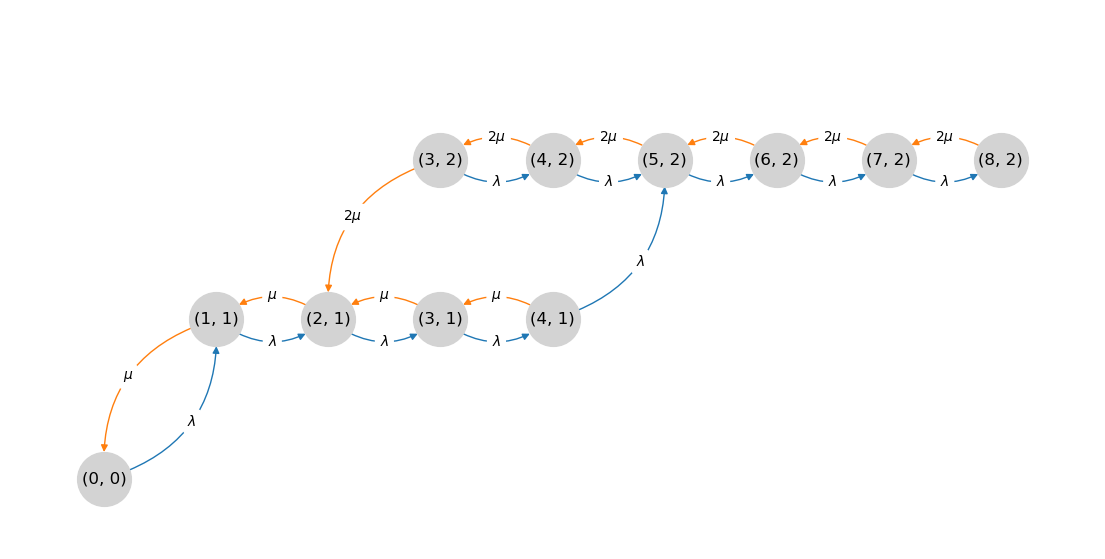

In [13]:
# Let's create a graph and plot it
G = createMyGraph(d1=2,d2=5, S=8, lam=1,mu=0.5)
drawMyGraph(G)

## Create the Rate Matrix from the Graph
The graph ```G``` is the input. The function returns the rate matrix $\cal{Q}$ as well as a mapping between the node identifier (which is the state) and the index in the matrix.

In [21]:
#%% Generate Markov Model
def createMyRateMatrix(G):
    """
    Draws the the state transition diagram described by the NetworkX graph G.
    
    Args:
        G (networkx.DiGraph): State transition graph.
        
    Returns:
        Q (np.array): State transition matrix used for computing system characteristics.
        n2i (dict): Mapping between the system states and the index of the rate matrix. The keys are the system states (x,y).
    """      
    n2i = {} # mapping between system states (x,y) and the index i of the matrix
    nodes = list(G.nodes)
    for i,node in enumerate(nodes):
        n2i[node] = i         
    Q = np.zeros((len(nodes),len(nodes))) # rate matrix
    
    for edge in G.edges:
        i0 = n2i[edge[0]]
        i1 = n2i[edge[1]]
        Q[i0,i1] = G[edge[0]][edge[1]]["weight"] 
        
    np.fill_diagonal(Q, -Q.sum(axis=1))
    return Q, n2i

In [20]:
Q, n2i = createMyRateMatrix(G)

# print(Q)

# let's print it nicely
from IPython.display import display, Math
latex_matrix = r'\cal{Q}=\begin{pmatrix}' + ' \\\\ '.join([' & '.join([f"{num:g}" for num in row]) for row in Q]) + r'\end{pmatrix}'
display(Math(latex_matrix))

print("\nMapping of states to indices:")
print(n2i)

<IPython.core.display.Math object>


Mapping of states to indices:
{(0, 0): 0, (1, 1): 1, (2, 1): 2, (3, 1): 3, (4, 1): 4, (5, 2): 5, (3, 2): 6, (4, 2): 7, (6, 2): 8, (7, 2): 9, (8, 2): 10}


## Compute System Characteristics based on the Steayd-State Probabilities

In [34]:
from scipy import linalg

def calcSystemCharacteristics(G, verbose=False):        
    """
    Computes some system characteristics for the given graph.
    
    Args:
        G (networkx.DiGraph): State transition graph.
        verbose (boolean): Print some computational steps (default: False).
        
    Returns:
        matrix (np.array): Two-dimensional steady-state probabilities P(X,Y).
        pX (np.array): Marginal distribution P(X=i).
        pY (np.array): Marginal distribution P(Y=i).
        pb (float): Blocking probability. 
        meanActiveServers (float): Average number of active servers.
        meanResponseTime (float): Average response time of accepted jobs.        
    """
    d1 = G.d1
    d2 = G.d2
    S = G.S
    
    # compute transition matrix
    Q2, n2i = createMyRateMatrix(G)
    if verbose:
        print(f'Q=\n{Q2}\n')
    
    Q2[:, -1] = 1
    if verbose:        
        print(f'Matrix is changed to\nQ2=\n{Q2}\n')

    b = np.zeros(len(Q2))
    b[-1] = 1
    if verbose:
        print(f'b=\n{b}\n')
    
    # state probabilities
    X = b @ linalg.inv(Q2) # compute the matrix inverse
    
    # Generate a matrix with P(X,Y)
    matrix = np.zeros((S+1,3))
    matrix[0,0] = X[ n2i[0,0] ]
    for i in range(1,d2):
        matrix[i,1] = X[ n2i[i,1] ] 
    
    for i in range(d1+1,S+1):
        matrix[i,2] = X[ n2i[i,2] ] 
        
    # compute margin distribution: P(X=i) 
    pX = matrix.sum(axis=1)
    
    # blocking probability
    pb = pX[-1]
    
    
    # compute margin distribution: P(Y=i) 
    pY = matrix.sum(axis=0)
            
    # average number of active servers
    meanActiveServers = pY @ np.arange(len(pY))
    
    # Mean response time using Little's theorem
    EXi = pX@np.arange(S+1)
    meanResponseTime = EXi/(G.lam*(1-pb))
        
    return matrix, pX, pY, pb , meanActiveServers, meanResponseTime

<IPython.core.display.Math object>

Blocking probability p_b = 0.146
Mean number of active servers = 1.708


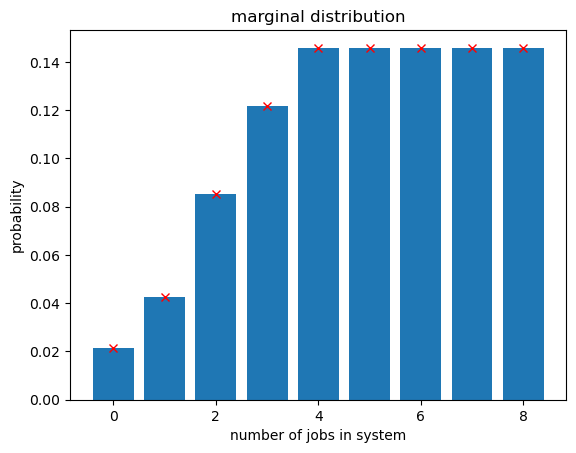

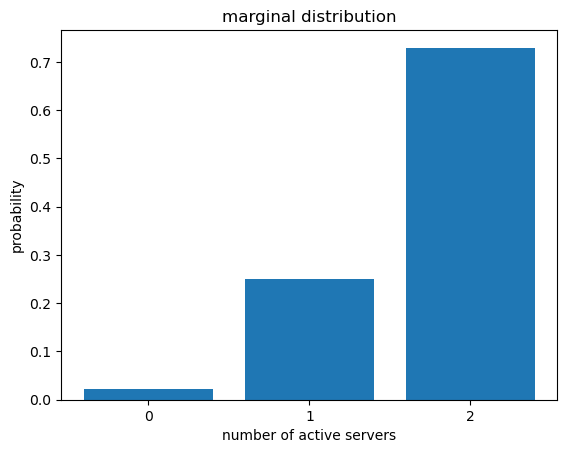

In [38]:
G = createMyGraph(d1=2,d2=5, S=8, lam=1,mu=0.5)
matrix, pX, pY, pb , meanActiveServers, meanResponseTime = calcSystemCharacteristics(G)

latex_matrix = r'{P(X,Y)}=\begin{pmatrix}' + ' \\\\ '.join([' & '.join([f"{num:g}" for num in row]) for row in matrix]) + r'\end{pmatrix}'
display(Math(latex_matrix))

print(f"Blocking probability p_b = {pb:.3f}")

print(f"Mean number of active servers = {meanActiveServers:.3f}")

plt.figure()
plt.bar(np.arange(len(pX)), pX)
plt.plot(matrix.sum(axis=1), 'rx')
plt.xlabel('number of jobs in system')
plt.ylabel('probability')
plt.title('marginal distribution')
plt.show();

plt.figure()
n = range(matrix.shape[1])
plt.bar(n, pY)
plt.xlabel('number of active servers')
plt.ylabel('probability')
plt.title('marginal distribution')
plt.xticks(n)
plt.show();
